# Activity 4.2. Document Clustering

(last modified 30 August 2023)

## Learning Outcomes

In this activity you will learn to:
- Perform feature extraction on text based data using CountVectorizer and Term Frequency-Inverse Document Frequency
- Perform dimensionality reduction using Principal Component Analysis to create interpretable visualisations
- Solve the Document Clustering problem using K-Means Clustering
- Use Normalised Mutual Information Index to measure the goodness of fit

## Prerequisites

- Lecture 8

## Document Clustering

In Lecture 8 we discussed the Document Clustering problem where we have a collection of n documents, which we try to group into K different clusters. We explored using Expectation Maximisation to solve this problem, which you may have to implement as part of Assignment 2. However, we also mentioned that the problem can also be solved using K-Means Clustering, which will be the focus of this activity. 


## KMeans Clustering


While we will not be implementing a KMeans clustering algorithm in this lab, it is worth understanding what objective the algorithm is trying to achieve during its' fitting process. 

The K-Means Clustering algorithm tries to separate the data into K clusters, such that each datapoint has minimal distance to the mean of the cluster it belongs to. For higher dimensional data, $\mu$ is the centroid of the points in the cluster. 

\begin{equation}
\argmin_S \sum_{i=1}^k \sum_{x\in S_i} ||x - \mu_i||^2 = \argmin_S \sum_{i=1}^k |S_i| Var(S_i)
\end{equation}

Finding the optimal solution to the problem is NP-hard, so most approaches to solving this problem involve using heuristics to find approximate solutions instead. 

## Task A: Aquiring Data

We use a subset of a publicly available dataset called 20 Newsgroups originally published in http://qwone.com/~jason/20Newsgroups/. This dataset contains more than 18K documents covering 20 different topics. For the simplicity and reducing the execution and evaluation times, we only use ~2700 samples randomly selected from 4 categories. The filtered data is stored in `20ng-train-all-terms.txt` file.

Read in the text file '20ng-train-all-terms.txt' and split the file up into individual documents and their associated label. Note that each line of the file contains a label followed by an article separated by \t. Then, store the data in a Pandas DataFrame for ease of visualisation. Note that we will continue to use Numpy arrays for all computational processes as this is faster and more efficient than Pandas. We can cast a Pandas DataFrame to a numpy array with the .values method. 

In [116]:
import pandas as pd 
import numpy as np

with open('20ng-train-all-terms.txt', 'r') as file:
    text = file.readlines()
all([length == 2 for length in [len(line.split('\t')) for line in text]])
labels, articles = [line.split('\t')[0].strip() for line in text], [line.split('\t')[1].strip() for line in text]
docs = pd.DataFrame(data = zip(labels,articles), columns=['label', 'article'])
docs.label = docs.label.astype('category')
docs.head()

,label,article
0,sci.crypt,ripem frequently asked questions archive name ...
1,sci.crypt,ripem frequently asked questions archive name ...
2,sci.crypt,ripem frequently noted vulnerabilities archive...
3,sci.crypt,certifying authority question answered if you ...
4,sci.crypt,rubber hose cryptanalysis some sick part of me...


## Task B: Feature Extraction

At the moment each of our documents are being stored as a single, very long string. This makes doing any analysis very inconventient. Instead of using our raw data directly, we will instead perform feature extraction on the data before doing our clustering. 

The features should be numerical, otherwise our Euclidean distance (non-similarity) measure will not work. 

To do so, we use `sklearn.feature_extraction.text.CountVectorizer` to tailor the texts and calculate word counts (frequency of each word in each single document) as the features.

Use the CountVectorizer to exctract features from the data. The min_df parameter controls the minimum number of times a word needs to be featured in the text before it is added to the feature space. Find a value for this feature that you feel is appropriate and justify your choice. 

In [117]:
from sklearn.feature_extraction.text import CountVectorizer

min_freq = 10
feature_options = []
for i in range(min_freq):
    cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=i+1)
    features = cv.fit_transform(raw_documents=articles)
    feature_options += [features]
    print(len(cv.get_feature_names_out()))

features = feature_options[4] # going with min_freq = 5
features.shape

30288
16806
12153
9724
8094
6986
6182
5562
5063
4593


(2373, 8094)

## Task C: Document Clustering with Kmeans

Implement an sklearn pipeline which takes as input raw text data, performs feature extraction using CountVectorizer and then fits the data using KMeans. Use the min_freq value you selected in Task B and assume we know the real number of clusters (4 newsgroups). Use this pipeline to fit the raw articles data. 

In [118]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5)
km = KMeans(n_clusters=4)

pipe = make_pipeline(cv, km)
pipe.fit(articles)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5, stop_words='english')),
                ('kmeans', KMeans(n_clusters=4))])

## Task D: Principal Component Analysis and Visualization
Recal that our feature space is a high-dimensional one and we cannot plot all the dimensions. 

Principal Component Analysis is an algorithm that can transform our data into a new coordinate system. In this new coordinate system, the features are constructed such that the first feature explains more of the variance in the data than all other features. The second feature explains more of the variance in the data than any feature other than the first, and so on. In this way, the features are ranked by their explanatory power. 

PCA is often commonly used technique for dimensionality reduction, as we can often discard all but a few of the most highly ranked features and still maintain much of the data's explanatory power. 

Use sklearn.decomposition.PCA to perform a PCA, extracting only first two principle components (components with the largest eigenvalues), then use these components to plot a lower dimensional represenation of our data. 

**Note:** The color codes can be very different in these plots as the cluster orders, and hence their labels and colors, can be very different.

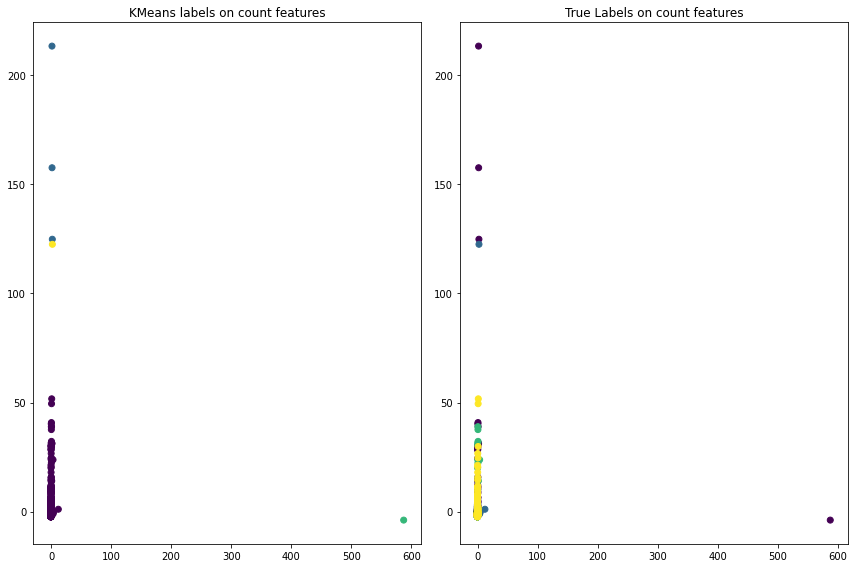

In [119]:
## perform pca
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

pca = PCA(n_components=2)
_2D_features = pca.fit_transform(features.toarray())

## plot the kmeans outcome
_, axs = plt.subplots(1, 2, figsize=(12, 8), tight_layout=True)
axs[0].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=km.labels_)
axs[0].set_title('KMeans labels on count features')


## plot the original data
axs[1].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=docs.label.cat.codes)
axs[1].set_title('True Labels on count features')
plt.show()


## Task E: A Simple Normalization
As the above figures, in some cases the data samples are located far from each other, while in some other cases, they are colocated. Also note that the scale of PCs can be very different. This suggests that with a normalization we might get better result as the performance of Kmeans is very sensitive to the distance between the points.

Use sklearn.preprocessing.Normalizer to normalise the data using the l2 norm and then refit KMeans on the newly normalised data. 
This can all be incorporated into a single pipeline that perorms feature extraction using CountVectorizer, then normalises the data using Normalizer then fits using KMeans. 

Finally, perform a 2 component PCA again, plot the results and compare them to the ones in the above plot. Has the fit improved? 

In [33]:
# normalise by dividing each feature row by its L2 norm
from sklearn.preprocessing import Normalizer
l2_norm = Normalizer(norm='l2')
features_normalised = l2_norm.fit_transform(features.toarray())

features_normalised.shape

(2373, 8094)

In [34]:
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5)
l2_norm = Normalizer(norm='l2')

km = KMeans(n_clusters=4)

pipe = make_pipeline(cv, l2_norm, km)
pipe.fit(articles)

/home/simon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=5, stop_words='english')),
                ('normalizer', Normalizer()),
                ('kmeans', KMeans(n_clusters=4))])

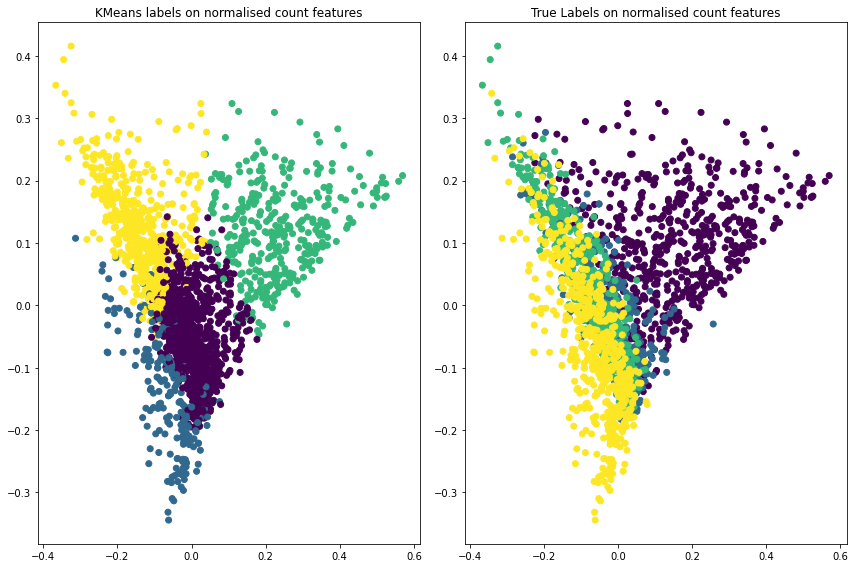

In [35]:
## perform pca
pca = PCA(n_components=2)
_2D_features = pca.fit_transform(features_normalised)

## plot the kmeans outcome
_, axs = plt.subplots(1, 2, figsize=(12, 8), tight_layout=True)
axs[0].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=km.labels_)
axs[0].set_title('KMeans labels on normalised count features')


## plot the original data
axs[1].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=docs.label.cat.codes)
axs[1].set_title('True Labels on normalised count features')
plt.show()


## Task F: A More Advanced Set of Features

The simple normalization improved Kmeans outcome, but not that much. This suggests that not only the initialization and number of clusters have great impact on the kmeans outcome, but the feature space itself should be discriminative as well. In the followings, we try another feature (instead of the simple word counts) that is knonw as Term Frequency-Inverse Document Frequency (TFIDF). In its core, TFIDF in nothing but weighted word count.

Let's calculate TFIDF feature values and then repeat the above experimetns. Implement another pipeline that performs feature extraction using TFIDF and then fits using KMeans. Note that we do not need to explictly include a normaliser in the pipeline as TfidfVectorizer can perform the normalisation itself if we set the norm argument. 

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5,
                    norm='l2')  # note that specifying the norm will normalise the data for us


features = tfidf.fit_transform(raw_documents=docs.article.values)

km = KMeans(n_clusters=4)

pipe = make_pipeline(tfidf, km)
pipe.fit(articles)

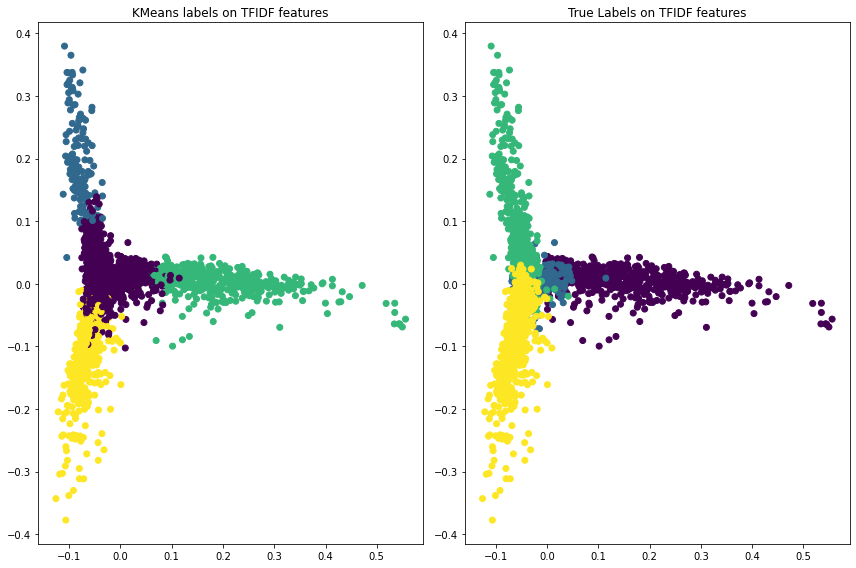

In [38]:
## perform pca
pca = PCA(n_components=2)
_2D_features = pca.fit_transform(features.toarray())

## plot the kmeans outcome
_, axs = plt.subplots(1, 2, figsize=(12, 8), tight_layout=True)
axs[0].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=km.labels_)
axs[0].set_title('KMeans labels on TFIDF features')


## plot the original data
axs[1].scatter(x=_2D_features[:,0],y=_2D_features[:,1], c=docs.label.cat.codes)
axs[1].set_title('True Labels on TFIDF features')
plt.show()


## Task G: Model Evaluation

To evaluate the alignment between our cluster predictions and the ground truth labels, we use a clustering evaluation metric such as normalised mutual information index. Note that we can not use a metric like `accuracy` because there is no guarantee that our cluster ids are aligned with our class label ids so instead we use a measure of mutual information such as NMI. (See [this source](https://towardsdatascience.com/7-evaluation-metrics-for-clustering-algorithms-bdc537ff54d2#ebd4) for more information)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import normalized_mutual_info_score as NMI

In [41]:
docs_train, docs_test = train_test_split(docs, test_size=0.2, random_state=123)
X_train, y_train = docs_train.article.values, docs_train.label.cat.codes
X_test, y_test = docs_test.article.values, docs_test.label.cat.codes

In [45]:
cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5, )

tfidf = TfidfVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5,
                    norm='l2')

l2_norm = Normalizer(norm='l2')

km = KMeans(n_clusters=4)

In [46]:
pipe_cv = make_pipeline(cv, l2_norm, km)
pipe_cv.fit(X_train)

NMI(pipe_cv.predict(X_train), y_train), NMI(pipe_cv.predict(X_test), y_test)

/home/simon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.3319044284043788, 0.31434932132520044)

In [47]:
pipe_tfidf = make_pipeline(tfidf, km)
pipe_tfidf.fit(X_train)

NMI(pipe_tfidf.predict(X_train), y_train), NMI(pipe_tfidf.predict(X_test), y_test)

/home/simon/.local/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(0.42857913067313197, 0.4232697524531802)

## Task H: Learning Curve

This results indicate that tfidf features may outperform CountVectors as a feature extraction method for this dataset, but let us confirm this suspicion by repeating the experiment many times, across many different dataset sizes. 

Complete the code in the cell below to generate the results necessary to plot a learning curve over the train size, comparing CountVectorizer and TfidfVectorizer as a method for creating features from our raw data. 

We will only perform 10 repetitions on 10 train sizes as this will already take around 5 minutes to run on most laptops.

After this, compute the mean and the size of the 1.96 standard error bar from res_array and use this to plot an errorbar comparing our two methods. Do these results align with what we saw in Task G? How confident are you in these results? 

In [102]:
from Activity4 import BootstrapSplitter

import warnings
warnings.filterwarnings('ignore')

train_sizes = np.logspace(start=0.8, stop=0.99, num=10, base=len(articles))/len(articles)
reps = 10

cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5, )

tfidf = TfidfVectorizer(lowercase=True,
                     stop_words='english',
                     min_df=5,
                    norm='l2')

l2_norm = Normalizer(norm='l2')

km = KMeans(n_clusters=4)

res_array = np.zeros(shape=(4, len(train_sizes), reps))
for i, train_size in enumerate(train_sizes):
    print('N_{0}={1}: rep='.format(i, int(train_size*len(articles))), end='')
    splitter = BootstrapSplitter(reps=reps, train_size=train_size, random_state=0)
    for j, (train_idx, test_idx) in enumerate(splitter.split(articles)):
        print('{0}'.format(j), end=', ')
        X_train, X_test, y_train, y_test = articles[train_idx], articles[test_idx], labels[train_idx], labels[test_idx]
        pipe_cv = make_pipeline(cv, l2_norm, km)
        pipe_cv.fit(X_train)
        res_array[0, i, j] = NMI(pipe_cv.predict(X_train), y_train)
        res_array[1, i, j] = NMI(pipe_cv.predict(X_test), y_test)

        pipe_tfidf = make_pipeline(tfidf, km)
        pipe_tfidf.fit(X_train)
        res_array[2, i, j] = NMI(pipe_tfidf.predict(X_train), y_train)
        res_array[3, i, j] = NMI(pipe_tfidf.predict(X_test), y_test)
    print()

N_0=501: rep=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
N_1=590: rep=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
N_2=696: rep=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
N_3=820: rep=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
N_4=966: rep=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
N_5=1138: rep=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
N_6=1342: rep=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
N_7=1581: rep=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
N_8=1863: rep=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 
N_9=2195: rep=0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 


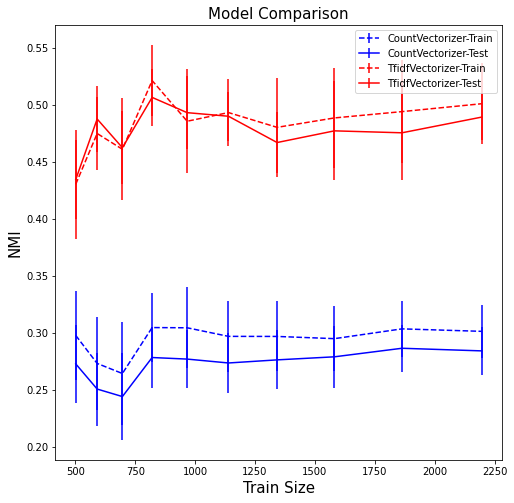

In [104]:
fig, axs = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(8)

mus = res_array.mean(axis=2)
stes = 1.96*res_array.std(axis=2)/np.sqrt(reps)

axs.errorbar(train_sizes*len(articles), mus[0, :], stes[0, :], label='CountVectorizer-Train', c='b', linestyle='--')
axs.errorbar(train_sizes*len(articles), mus[1, :], stes[1, :], label='CountVectorizer-Test', c='b', linestyle='-')
axs.errorbar(train_sizes*len(articles), mus[2, :], stes[2, :], label='TfidfVectorizer-Train', c='r',  linestyle='--')
axs.errorbar(train_sizes*len(articles), mus[3, :], stes[3, :], label='TfidfVectorizer-Test', c='r',  linestyle='-')
axs.set_xlabel('Train Size', size=15)
axs.set_ylabel('NMI', size=15)
axs.set_title('Model Comparison', size=15)
axs.legend()

## Discussions:
1- We knew that KMeans is very sensitive to its initialzation (initial cluster centers) and number of clusters (`k`). Apart from that, what is the other main limitation of Kmeans algorithm (**Hint:** Think of features set and distance metric)?

2- Given the limitaitons we encounter in the previous questions, what could be the remedy (**Hint:** Think of EM techniques that are covered in the previous chapter)?